In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, next_states, rewards, dones, rates

In [4]:
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        actions_logits = tf.layers.dense(inputs=nl2, units=action_size)
        return actions_logits

In [5]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        Qs_logits = tf.layers.dense(inputs=nl2, units=1)
        return Qs_logits

In [6]:
def model_loss(state_size, action_size, hidden_size, 
               states, actions, next_states, rewards, dones, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    gloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    dQs = discriminator(states=states, actions=actions_labels, action_size=action_size, hidden_size=hidden_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                   labels=rates)) # [0, 1]
    next_actions_logits = generator(states=next_states, hidden_size=hidden_size, action_size=action_size, 
                                    reuse=True)
    nextQs_logits = discriminator(states=next_states, actions=next_actions_logits, action_size=action_size, 
                                  hidden_size=hidden_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1])
    targetQs = rewards + (0.99 * nextQs * (1-dones))
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    glossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                    labels=tf.nn.sigmoid(targetQs))) # [0, 1]
    return actions_logits, gloss, dloss, glossQ

In [7]:
def model_opt(g_loss, d_loss, g_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        g_optQ = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossQ, var_list=g_vars)
    return g_opt, d_opt, g_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_loss, self.d_loss, self.g_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size, # model init parameters
            states=self.states, actions=self.actions, next_states=self.next_states, rewards=self.rewards, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.g_optQ = model_opt(g_loss=self.g_loss, 
                                                        d_loss=self.d_loss,
                                                        g_lossQ=self.g_lossQ,
                                                        g_learning_rate=g_learning_rate, 
                                                        d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500 # [0, 1]
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # [0, 1]
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1:
                        memory.buffer[-1-idx][-1] = rate
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            gloss, _, dloss, _ = sess.run([model.g_loss, model.g_opt, model.d_loss, model.d_opt], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones, 
                                                       model.rates: rates})
            glossQ, _ = sess.run([model.g_lossQ, model.g_optQ], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones, 
                                                       model.rates: rates})
            dloss_batch.append(dloss)
            gloss_batch.append(gloss)
            glossQ_batch.append(glossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:0.6900 dloss:0.5700 glossQ:0.8240 exploreP:0.9981
Episode:1 meanR:17.5000 R:16.0000 rate:0.0320 gloss:0.6913 dloss:0.5581 glossQ:0.8316 exploreP:0.9965
Episode:2 meanR:15.6667 R:12.0000 rate:0.0240 gloss:0.6911 dloss:0.5499 glossQ:0.8353 exploreP:0.9954
Episode:3 meanR:14.5000 R:11.0000 rate:0.0220 gloss:0.6905 dloss:0.5630 glossQ:0.8342 exploreP:0.9943
Episode:4 meanR:16.2000 R:23.0000 rate:0.0460 gloss:0.6902 dloss:0.5390 glossQ:0.8377 exploreP:0.9920
Episode:5 meanR:16.1667 R:16.0000 rate:0.0320 gloss:0.6880 dloss:0.5559 glossQ:0.8459 exploreP:0.9904
Episode:6 meanR:18.7143 R:34.0000 rate:0.0680 gloss:0.6901 dloss:0.5409 glossQ:0.8440 exploreP:0.9871
Episode:7 meanR:17.8750 R:12.0000 rate:0.0240 gloss:0.6909 dloss:0.5397 glossQ:0.8416 exploreP:0.9859
Episode:8 meanR:17.6667 R:16.0000 rate:0.0320 gloss:0.6893 dloss:0.5331 glossQ:0.8452 exploreP:0.9844
Episode:9 meanR:18.2000 R:23.0000 rate:0.0460 gloss:0.6911 dloss:0.5287 glossQ:0.8

Episode:80 meanR:24.9259 R:10.0000 rate:0.0200 gloss:0.6715 dloss:0.4037 glossQ:0.2453 exploreP:0.8190
Episode:81 meanR:25.1220 R:41.0000 rate:0.0820 gloss:0.6791 dloss:0.3876 glossQ:0.2476 exploreP:0.8157
Episode:82 meanR:25.5783 R:63.0000 rate:0.1260 gloss:0.6765 dloss:0.3800 glossQ:0.2421 exploreP:0.8106
Episode:83 meanR:26.0952 R:69.0000 rate:0.1380 gloss:0.6786 dloss:0.3838 glossQ:0.2298 exploreP:0.8051
Episode:84 meanR:25.9882 R:17.0000 rate:0.0340 gloss:0.6728 dloss:0.3995 glossQ:0.2250 exploreP:0.8038
Episode:85 meanR:25.8372 R:13.0000 rate:0.0260 gloss:0.6815 dloss:0.3884 glossQ:0.2182 exploreP:0.8027
Episode:86 meanR:25.8161 R:24.0000 rate:0.0480 gloss:0.6712 dloss:0.3833 glossQ:0.2210 exploreP:0.8008
Episode:87 meanR:25.7955 R:24.0000 rate:0.0480 gloss:0.6712 dloss:0.3963 glossQ:0.2176 exploreP:0.7990
Episode:88 meanR:25.8876 R:34.0000 rate:0.0680 gloss:0.6757 dloss:0.3973 glossQ:0.2164 exploreP:0.7963
Episode:89 meanR:25.8667 R:24.0000 rate:0.0480 gloss:0.6774 dloss:0.4031 

Episode:159 meanR:51.9000 R:25.0000 rate:0.0500 gloss:0.6719 dloss:0.3940 glossQ:0.1781 exploreP:0.5242
Episode:160 meanR:52.1400 R:37.0000 rate:0.0740 gloss:0.6687 dloss:0.3733 glossQ:0.1707 exploreP:0.5223
Episode:161 meanR:53.5600 R:167.0000 rate:0.3340 gloss:0.6694 dloss:0.3901 glossQ:0.1715 exploreP:0.5139
Episode:162 meanR:53.8100 R:73.0000 rate:0.1460 gloss:0.6732 dloss:0.3881 glossQ:0.1684 exploreP:0.5102
Episode:163 meanR:55.7200 R:223.0000 rate:0.4460 gloss:0.6735 dloss:0.3948 glossQ:0.1716 exploreP:0.4992
Episode:164 meanR:56.1500 R:69.0000 rate:0.1380 gloss:0.6727 dloss:0.4152 glossQ:0.1708 exploreP:0.4958
Episode:165 meanR:58.3000 R:234.0000 rate:0.4680 gloss:0.6750 dloss:0.3932 glossQ:0.1810 exploreP:0.4846
Episode:166 meanR:61.3500 R:357.0000 rate:0.7140 gloss:0.6691 dloss:0.4024 glossQ:0.1739 exploreP:0.4679
Episode:167 meanR:63.7200 R:310.0000 rate:0.6200 gloss:0.6700 dloss:0.4109 glossQ:0.1776 exploreP:0.4539
Episode:168 meanR:65.1000 R:153.0000 rate:0.3060 gloss:0.66

Episode:237 meanR:311.2400 R:222.0000 rate:0.4440 gloss:0.6565 dloss:0.5903 glossQ:0.4327 exploreP:0.0371
Episode:238 meanR:312.4600 R:167.0000 rate:0.3340 gloss:0.6439 dloss:0.6186 glossQ:0.4535 exploreP:0.0367
Episode:239 meanR:313.2000 R:122.0000 rate:0.2440 gloss:0.6510 dloss:0.5955 glossQ:0.4517 exploreP:0.0364
Episode:240 meanR:313.1400 R:160.0000 rate:0.3200 gloss:0.6551 dloss:0.5988 glossQ:0.4527 exploreP:0.0360
Episode:241 meanR:314.1000 R:131.0000 rate:0.2620 gloss:0.6502 dloss:0.6144 glossQ:0.4717 exploreP:0.0356
Episode:242 meanR:314.1600 R:112.0000 rate:0.2240 gloss:0.6516 dloss:0.5928 glossQ:0.4842 exploreP:0.0353
Episode:243 meanR:314.7500 R:146.0000 rate:0.2920 gloss:0.6538 dloss:0.6106 glossQ:0.4622 exploreP:0.0350
Episode:244 meanR:314.8300 R:36.0000 rate:0.0720 gloss:0.6888 dloss:0.6125 glossQ:0.4669 exploreP:0.0349
Episode:245 meanR:314.2900 R:50.0000 rate:0.1000 gloss:0.6871 dloss:0.5911 glossQ:0.4611 exploreP:0.0347
Episode:246 meanR:313.7300 R:52.0000 rate:0.1040

Episode:315 meanR:123.0800 R:60.0000 rate:0.1200 gloss:0.7161 dloss:0.6128 glossQ:0.4762 exploreP:0.0298
Episode:316 meanR:118.2500 R:17.0000 rate:0.0340 gloss:0.8355 dloss:0.5908 glossQ:0.4477 exploreP:0.0298
Episode:317 meanR:114.3200 R:34.0000 rate:0.0680 gloss:0.7347 dloss:0.6264 glossQ:0.4790 exploreP:0.0297
Episode:318 meanR:109.4500 R:13.0000 rate:0.0260 gloss:0.8492 dloss:0.6009 glossQ:0.4769 exploreP:0.0297
Episode:319 meanR:104.5400 R:9.0000 rate:0.0180 gloss:1.4325 dloss:0.7120 glossQ:0.5141 exploreP:0.0297
Episode:320 meanR:99.6300 R:9.0000 rate:0.0180 gloss:2.2834 dloss:0.5935 glossQ:0.4535 exploreP:0.0297
Episode:321 meanR:96.8800 R:9.0000 rate:0.0180 gloss:3.0485 dloss:0.5403 glossQ:0.4668 exploreP:0.0297
Episode:322 meanR:91.9800 R:10.0000 rate:0.0200 gloss:3.6293 dloss:0.5792 glossQ:0.4756 exploreP:0.0296
Episode:323 meanR:87.0800 R:10.0000 rate:0.0200 gloss:3.9635 dloss:0.6433 glossQ:0.5275 exploreP:0.0296
Episode:324 meanR:82.1800 R:10.0000 rate:0.0200 gloss:4.0457 d

Episode:394 meanR:16.2400 R:9.0000 rate:0.0180 gloss:13.8407 dloss:0.5651 glossQ:0.5318 exploreP:0.0283
Episode:395 meanR:16.1400 R:10.0000 rate:0.0200 gloss:15.0127 dloss:0.6205 glossQ:0.4764 exploreP:0.0283
Episode:396 meanR:16.0800 R:8.0000 rate:0.0160 gloss:14.4189 dloss:0.5740 glossQ:0.5445 exploreP:0.0283
Episode:397 meanR:15.9000 R:10.0000 rate:0.0200 gloss:14.3750 dloss:0.5939 glossQ:0.5264 exploreP:0.0283
Episode:398 meanR:15.8300 R:10.0000 rate:0.0200 gloss:15.2771 dloss:0.5666 glossQ:0.5264 exploreP:0.0283
Episode:399 meanR:15.8200 R:10.0000 rate:0.0200 gloss:15.0048 dloss:0.5812 glossQ:0.5373 exploreP:0.0283
Episode:400 meanR:15.8300 R:10.0000 rate:0.0200 gloss:14.1463 dloss:0.6660 glossQ:0.6090 exploreP:0.0282
Episode:401 meanR:15.8300 R:10.0000 rate:0.0200 gloss:15.2116 dloss:0.5689 glossQ:0.6602 exploreP:0.0282
Episode:402 meanR:15.8600 R:11.0000 rate:0.0220 gloss:17.6747 dloss:0.5306 glossQ:0.6365 exploreP:0.0282
Episode:403 meanR:15.8200 R:9.0000 rate:0.0180 gloss:17.9

Episode:474 meanR:9.6100 R:9.0000 rate:0.0180 gloss:2.4802 dloss:0.5956 glossQ:1.1424 exploreP:0.0270
Episode:475 meanR:9.5900 R:8.0000 rate:0.0160 gloss:2.0520 dloss:0.5542 glossQ:1.1794 exploreP:0.0270
Episode:476 meanR:9.5700 R:9.0000 rate:0.0180 gloss:2.0698 dloss:0.5549 glossQ:1.1241 exploreP:0.0269
Episode:477 meanR:9.5600 R:9.0000 rate:0.0180 gloss:1.3998 dloss:0.6856 glossQ:0.9953 exploreP:0.0269
Episode:478 meanR:9.5800 R:11.0000 rate:0.0220 gloss:1.3593 dloss:0.5266 glossQ:1.2670 exploreP:0.0269
Episode:479 meanR:9.6400 R:16.0000 rate:0.0320 gloss:1.0159 dloss:0.5560 glossQ:1.1287 exploreP:0.0269
Episode:480 meanR:10.5100 R:96.0000 rate:0.1920 gloss:0.8243 dloss:0.5895 glossQ:1.1107 exploreP:0.0267
Episode:481 meanR:11.4900 R:107.0000 rate:0.2140 gloss:0.7910 dloss:0.5818 glossQ:1.1529 exploreP:0.0265
Episode:482 meanR:12.6300 R:124.0000 rate:0.2480 gloss:0.7833 dloss:0.5895 glossQ:1.1817 exploreP:0.0263
Episode:483 meanR:13.6200 R:108.0000 rate:0.2160 gloss:0.7687 dloss:0.62

Episode:552 meanR:147.8900 R:376.0000 rate:0.7520 gloss:0.6337 dloss:0.6099 glossQ:0.9596 exploreP:0.0140
Episode:553 meanR:149.3100 R:153.0000 rate:0.3060 gloss:0.6323 dloss:0.6174 glossQ:0.9711 exploreP:0.0139
Episode:554 meanR:150.5100 R:130.0000 rate:0.2600 gloss:0.6580 dloss:0.5949 glossQ:1.0124 exploreP:0.0138
Episode:555 meanR:152.6100 R:222.0000 rate:0.4440 gloss:0.6237 dloss:0.6025 glossQ:0.9317 exploreP:0.0138
Episode:556 meanR:154.0700 R:156.0000 rate:0.3120 gloss:0.6194 dloss:0.6171 glossQ:0.9100 exploreP:0.0137
Episode:557 meanR:155.6500 R:166.0000 rate:0.3320 gloss:0.6286 dloss:0.6038 glossQ:0.9405 exploreP:0.0136
Episode:558 meanR:157.2700 R:170.0000 rate:0.3400 gloss:0.6494 dloss:0.5976 glossQ:1.0189 exploreP:0.0136
Episode:559 meanR:158.8400 R:165.0000 rate:0.3300 gloss:0.6210 dloss:0.6239 glossQ:0.8939 exploreP:0.0135
Episode:560 meanR:160.5500 R:181.0000 rate:0.3620 gloss:0.6304 dloss:0.6036 glossQ:0.8966 exploreP:0.0135
Episode:561 meanR:162.0000 R:154.0000 rate:0.3

Episode:630 meanR:178.2100 R:177.0000 rate:0.3540 gloss:0.5981 dloss:0.6283 glossQ:0.8585 exploreP:0.0110
Episode:631 meanR:177.6800 R:164.0000 rate:0.3280 gloss:0.6106 dloss:0.6198 glossQ:0.8532 exploreP:0.0110
Episode:632 meanR:177.5600 R:161.0000 rate:0.3220 gloss:0.5891 dloss:0.6314 glossQ:0.8121 exploreP:0.0110
Episode:633 meanR:175.2600 R:187.0000 rate:0.3740 gloss:0.5713 dloss:0.6268 glossQ:0.7369 exploreP:0.0110
Episode:634 meanR:175.7900 R:201.0000 rate:0.4020 gloss:0.5909 dloss:0.6193 glossQ:0.8076 exploreP:0.0110
Episode:635 meanR:175.9600 R:158.0000 rate:0.3160 gloss:0.6130 dloss:0.6314 glossQ:0.8788 exploreP:0.0110
Episode:636 meanR:175.7500 R:145.0000 rate:0.2900 gloss:0.5945 dloss:0.6206 glossQ:0.8354 exploreP:0.0109
Episode:637 meanR:173.9900 R:118.0000 rate:0.2360 gloss:0.5719 dloss:0.6290 glossQ:0.7463 exploreP:0.0109
Episode:638 meanR:174.5900 R:289.0000 rate:0.5780 gloss:0.5801 dloss:0.6267 glossQ:0.7566 exploreP:0.0109
Episode:639 meanR:175.2500 R:223.0000 rate:0.4

Episode:708 meanR:186.8600 R:153.0000 rate:0.3060 gloss:0.5413 dloss:0.6479 glossQ:0.6497 exploreP:0.0102
Episode:709 meanR:186.5600 R:156.0000 rate:0.3120 gloss:0.5404 dloss:0.6434 glossQ:0.6833 exploreP:0.0102
Episode:710 meanR:186.6300 R:150.0000 rate:0.3000 gloss:0.5176 dloss:0.6268 glossQ:0.6379 exploreP:0.0102
Episode:711 meanR:188.0700 R:303.0000 rate:0.6060 gloss:0.5420 dloss:0.6311 glossQ:0.6438 exploreP:0.0102
Episode:712 meanR:188.7500 R:227.0000 rate:0.4540 gloss:0.5179 dloss:0.6277 glossQ:0.6096 exploreP:0.0102
Episode:713 meanR:188.0600 R:135.0000 rate:0.2700 gloss:0.5345 dloss:0.6349 glossQ:0.6400 exploreP:0.0102
Episode:714 meanR:188.0300 R:144.0000 rate:0.2880 gloss:0.5008 dloss:0.6345 glossQ:0.6143 exploreP:0.0102
Episode:715 meanR:188.0600 R:169.0000 rate:0.3380 gloss:0.5128 dloss:0.6189 glossQ:0.6009 exploreP:0.0102
Episode:716 meanR:187.6300 R:162.0000 rate:0.3240 gloss:0.5089 dloss:0.6421 glossQ:0.5880 exploreP:0.0102
Episode:717 meanR:187.9400 R:163.0000 rate:0.3

Episode:786 meanR:190.7400 R:176.0000 rate:0.3520 gloss:0.3845 dloss:0.6008 glossQ:0.4289 exploreP:0.0101
Episode:787 meanR:191.0000 R:197.0000 rate:0.3940 gloss:0.4027 dloss:0.6432 glossQ:0.4908 exploreP:0.0101
Episode:788 meanR:190.8000 R:147.0000 rate:0.2940 gloss:0.3986 dloss:0.6391 glossQ:0.4717 exploreP:0.0101
Episode:789 meanR:191.0400 R:163.0000 rate:0.3260 gloss:0.3769 dloss:0.6192 glossQ:0.4776 exploreP:0.0101
Episode:790 meanR:191.7500 R:208.0000 rate:0.4160 gloss:0.4027 dloss:0.6017 glossQ:0.4634 exploreP:0.0100
Episode:791 meanR:190.9200 R:133.0000 rate:0.2660 gloss:0.3922 dloss:0.6304 glossQ:0.4622 exploreP:0.0100
Episode:792 meanR:191.3000 R:209.0000 rate:0.4180 gloss:0.4146 dloss:0.6062 glossQ:0.4555 exploreP:0.0100
Episode:793 meanR:191.3400 R:167.0000 rate:0.3340 gloss:0.4193 dloss:0.6210 glossQ:0.4956 exploreP:0.0100
Episode:794 meanR:190.7700 R:145.0000 rate:0.2900 gloss:0.4012 dloss:0.5913 glossQ:0.4649 exploreP:0.0100
Episode:795 meanR:188.4700 R:190.0000 rate:0.3

Episode:864 meanR:192.1700 R:238.0000 rate:0.4760 gloss:0.2780 dloss:0.5985 glossQ:0.4450 exploreP:0.0100
Episode:865 meanR:189.2100 R:140.0000 rate:0.2800 gloss:0.2905 dloss:0.6179 glossQ:0.4338 exploreP:0.0100
Episode:866 meanR:189.1900 R:140.0000 rate:0.2800 gloss:0.2682 dloss:0.6289 glossQ:0.4283 exploreP:0.0100
Episode:867 meanR:188.1800 R:177.0000 rate:0.3540 gloss:0.2839 dloss:0.6205 glossQ:0.4603 exploreP:0.0100
Episode:868 meanR:186.2000 R:141.0000 rate:0.2820 gloss:0.3240 dloss:0.5997 glossQ:0.4585 exploreP:0.0100
Episode:869 meanR:187.0800 R:249.0000 rate:0.4980 gloss:0.2639 dloss:0.6251 glossQ:0.4409 exploreP:0.0100
Episode:870 meanR:187.8500 R:215.0000 rate:0.4300 gloss:0.2768 dloss:0.6216 glossQ:0.4440 exploreP:0.0100
Episode:871 meanR:188.1200 R:164.0000 rate:0.3280 gloss:0.3113 dloss:0.6178 glossQ:0.4462 exploreP:0.0100
Episode:872 meanR:188.7400 R:204.0000 rate:0.4080 gloss:0.2913 dloss:0.6160 glossQ:0.4518 exploreP:0.0100
Episode:873 meanR:188.9700 R:168.0000 rate:0.3

Episode:942 meanR:193.5600 R:170.0000 rate:0.3400 gloss:0.2409 dloss:0.6804 glossQ:0.5586 exploreP:0.0100
Episode:943 meanR:192.9500 R:125.0000 rate:0.2500 gloss:0.1880 dloss:0.6818 glossQ:0.5598 exploreP:0.0100
Episode:944 meanR:193.0500 R:164.0000 rate:0.3280 gloss:0.2329 dloss:0.6861 glossQ:0.5959 exploreP:0.0100
Episode:945 meanR:192.2300 R:157.0000 rate:0.3140 gloss:0.2261 dloss:0.6723 glossQ:0.5704 exploreP:0.0100
Episode:946 meanR:190.9800 R:170.0000 rate:0.3400 gloss:0.2124 dloss:0.6652 glossQ:0.5249 exploreP:0.0100
Episode:947 meanR:191.8400 R:266.0000 rate:0.5320 gloss:0.2204 dloss:0.6829 glossQ:0.5479 exploreP:0.0100
Episode:948 meanR:192.1500 R:182.0000 rate:0.3640 gloss:0.2266 dloss:0.6735 glossQ:0.5457 exploreP:0.0100
Episode:949 meanR:191.9400 R:161.0000 rate:0.3220 gloss:0.2106 dloss:0.6779 glossQ:0.5466 exploreP:0.0100
Episode:950 meanR:192.0600 R:177.0000 rate:0.3540 gloss:0.2396 dloss:0.6776 glossQ:0.5679 exploreP:0.0100
Episode:951 meanR:192.6300 R:262.0000 rate:0.5

Episode:1020 meanR:185.1800 R:287.0000 rate:0.5740 gloss:0.1662 dloss:0.6839 glossQ:0.5709 exploreP:0.0100
Episode:1021 meanR:184.1300 R:181.0000 rate:0.3620 gloss:0.1571 dloss:0.6897 glossQ:0.6011 exploreP:0.0100
Episode:1022 meanR:184.6400 R:224.0000 rate:0.4480 gloss:0.1520 dloss:0.6859 glossQ:0.5936 exploreP:0.0100
Episode:1023 meanR:184.9600 R:248.0000 rate:0.4960 gloss:0.1649 dloss:0.6873 glossQ:0.5846 exploreP:0.0100
Episode:1024 meanR:184.2700 R:134.0000 rate:0.2680 gloss:0.1459 dloss:0.6824 glossQ:0.5778 exploreP:0.0100
Episode:1025 meanR:185.5600 R:292.0000 rate:0.5840 gloss:0.1548 dloss:0.6882 glossQ:0.5719 exploreP:0.0100
Episode:1026 meanR:184.8800 R:127.0000 rate:0.2540 gloss:0.1576 dloss:0.6861 glossQ:0.5936 exploreP:0.0100
Episode:1027 meanR:183.9300 R:182.0000 rate:0.3640 gloss:0.1540 dloss:0.6854 glossQ:0.5838 exploreP:0.0100
Episode:1028 meanR:183.8900 R:237.0000 rate:0.4740 gloss:0.1541 dloss:0.6868 glossQ:0.5843 exploreP:0.0100
Episode:1029 meanR:183.6200 R:141.000

Episode:1097 meanR:190.9100 R:190.0000 rate:0.3800 gloss:0.1243 dloss:0.6881 glossQ:0.6039 exploreP:0.0100
Episode:1098 meanR:192.5900 R:338.0000 rate:0.6760 gloss:0.1262 dloss:0.6897 glossQ:0.6003 exploreP:0.0100
Episode:1099 meanR:192.3200 R:162.0000 rate:0.3240 gloss:0.1222 dloss:0.6878 glossQ:0.6042 exploreP:0.0100
Episode:1100 meanR:192.8800 R:191.0000 rate:0.3820 gloss:0.1252 dloss:0.6893 glossQ:0.6027 exploreP:0.0100
Episode:1101 meanR:192.5100 R:159.0000 rate:0.3180 gloss:0.1223 dloss:0.6875 glossQ:0.6060 exploreP:0.0100
Episode:1102 meanR:192.3000 R:174.0000 rate:0.3480 gloss:0.1143 dloss:0.6877 glossQ:0.5955 exploreP:0.0100
Episode:1103 meanR:192.4800 R:182.0000 rate:0.3640 gloss:0.1140 dloss:0.6919 glossQ:0.6045 exploreP:0.0100
Episode:1104 meanR:192.6500 R:186.0000 rate:0.3720 gloss:0.1267 dloss:0.6886 glossQ:0.6150 exploreP:0.0100
Episode:1105 meanR:192.1600 R:136.0000 rate:0.2720 gloss:0.1176 dloss:0.6897 glossQ:0.6112 exploreP:0.0100
Episode:1106 meanR:191.0000 R:148.000

Episode:1174 meanR:194.9800 R:144.0000 rate:0.2880 gloss:0.0970 dloss:0.6843 glossQ:0.5437 exploreP:0.0100
Episode:1175 meanR:194.7300 R:225.0000 rate:0.4500 gloss:0.1057 dloss:0.6828 glossQ:0.5563 exploreP:0.0100
Episode:1176 meanR:194.2300 R:140.0000 rate:0.2800 gloss:0.0942 dloss:0.6848 glossQ:0.5716 exploreP:0.0100
Episode:1177 meanR:193.3900 R:168.0000 rate:0.3360 gloss:0.1000 dloss:0.6828 glossQ:0.5703 exploreP:0.0100
Episode:1178 meanR:193.2600 R:153.0000 rate:0.3060 gloss:0.1051 dloss:0.6889 glossQ:0.5806 exploreP:0.0100
Episode:1179 meanR:193.5600 R:219.0000 rate:0.4380 gloss:0.1059 dloss:0.6821 glossQ:0.5788 exploreP:0.0100
Episode:1180 meanR:194.2000 R:218.0000 rate:0.4360 gloss:0.1019 dloss:0.6815 glossQ:0.5603 exploreP:0.0100
Episode:1181 meanR:193.5000 R:177.0000 rate:0.3540 gloss:0.1003 dloss:0.6843 glossQ:0.5683 exploreP:0.0100
Episode:1182 meanR:193.4100 R:171.0000 rate:0.3420 gloss:0.1089 dloss:0.6807 glossQ:0.5731 exploreP:0.0100
Episode:1183 meanR:193.0500 R:134.000

Episode:1251 meanR:199.7700 R:256.0000 rate:0.5120 gloss:0.0879 dloss:0.6849 glossQ:0.5894 exploreP:0.0100
Episode:1252 meanR:197.7400 R:133.0000 rate:0.2660 gloss:0.0838 dloss:0.6887 glossQ:0.6017 exploreP:0.0100
Episode:1253 meanR:197.9000 R:172.0000 rate:0.3440 gloss:0.0950 dloss:0.6859 glossQ:0.5940 exploreP:0.0100
Episode:1254 meanR:198.0500 R:216.0000 rate:0.4320 gloss:0.0896 dloss:0.6816 glossQ:0.5787 exploreP:0.0100
Episode:1255 meanR:198.7000 R:211.0000 rate:0.4220 gloss:0.0812 dloss:0.6908 glossQ:0.5809 exploreP:0.0100
Episode:1256 meanR:198.6800 R:208.0000 rate:0.4160 gloss:0.0842 dloss:0.6873 glossQ:0.6028 exploreP:0.0100
Episode:1257 meanR:199.0100 R:176.0000 rate:0.3520 gloss:0.0874 dloss:0.6874 glossQ:0.6002 exploreP:0.0100
Episode:1258 meanR:198.8300 R:162.0000 rate:0.3240 gloss:0.0871 dloss:0.6903 glossQ:0.6125 exploreP:0.0100
Episode:1259 meanR:197.5700 R:127.0000 rate:0.2540 gloss:0.0843 dloss:0.6889 glossQ:0.6100 exploreP:0.0100
Episode:1260 meanR:196.2400 R:166.000

Episode:1328 meanR:206.1900 R:161.0000 rate:0.3220 gloss:0.0775 dloss:0.6825 glossQ:0.5727 exploreP:0.0100
Episode:1329 meanR:207.0900 R:243.0000 rate:0.4860 gloss:0.0816 dloss:0.6855 glossQ:0.5820 exploreP:0.0100
Episode:1330 meanR:207.6200 R:240.0000 rate:0.4800 gloss:0.0755 dloss:0.6878 glossQ:0.5875 exploreP:0.0100
Episode:1331 meanR:208.7100 R:248.0000 rate:0.4960 gloss:0.0783 dloss:0.6858 glossQ:0.5875 exploreP:0.0100
Episode:1332 meanR:208.4900 R:153.0000 rate:0.3060 gloss:0.0836 dloss:0.6893 glossQ:0.5979 exploreP:0.0100
Episode:1333 meanR:208.7800 R:258.0000 rate:0.5160 gloss:0.0806 dloss:0.6878 glossQ:0.5993 exploreP:0.0100
Episode:1334 meanR:207.7400 R:171.0000 rate:0.3420 gloss:0.0745 dloss:0.6890 glossQ:0.6106 exploreP:0.0100
Episode:1335 meanR:207.8800 R:205.0000 rate:0.4100 gloss:0.0822 dloss:0.6862 glossQ:0.6004 exploreP:0.0100
Episode:1336 meanR:205.8900 R:139.0000 rate:0.2780 gloss:0.0835 dloss:0.6855 glossQ:0.5905 exploreP:0.0100
Episode:1337 meanR:206.4100 R:271.000

Episode:1405 meanR:199.8300 R:146.0000 rate:0.2920 gloss:0.0762 dloss:0.6885 glossQ:0.6099 exploreP:0.0100
Episode:1406 meanR:199.8600 R:273.0000 rate:0.5460 gloss:0.0737 dloss:0.6903 glossQ:0.6179 exploreP:0.0100
Episode:1407 meanR:198.4400 R:136.0000 rate:0.2720 gloss:0.0696 dloss:0.6884 glossQ:0.6152 exploreP:0.0100
Episode:1408 meanR:197.3800 R:237.0000 rate:0.4740 gloss:0.0662 dloss:0.6877 glossQ:0.6095 exploreP:0.0100
Episode:1409 meanR:198.5500 R:393.0000 rate:0.7860 gloss:0.0706 dloss:0.6891 glossQ:0.6086 exploreP:0.0100
Episode:1410 meanR:197.7100 R:158.0000 rate:0.3160 gloss:0.0732 dloss:0.6891 glossQ:0.6059 exploreP:0.0100
Episode:1411 meanR:196.3400 R:161.0000 rate:0.3220 gloss:0.0664 dloss:0.6899 glossQ:0.6188 exploreP:0.0100
Episode:1412 meanR:198.0200 R:306.0000 rate:0.6120 gloss:0.0643 dloss:0.6870 glossQ:0.6018 exploreP:0.0100
Episode:1413 meanR:197.7300 R:172.0000 rate:0.3440 gloss:0.0647 dloss:0.6848 glossQ:0.6017 exploreP:0.0100
Episode:1414 meanR:197.6100 R:205.000

Episode:1482 meanR:191.7700 R:149.0000 rate:0.2980 gloss:0.0679 dloss:0.6899 glossQ:0.6066 exploreP:0.0100
Episode:1483 meanR:191.5800 R:140.0000 rate:0.2800 gloss:0.0694 dloss:0.6913 glossQ:0.6151 exploreP:0.0100
Episode:1484 meanR:192.2900 R:250.0000 rate:0.5000 gloss:0.0642 dloss:0.6896 glossQ:0.6277 exploreP:0.0100
Episode:1485 meanR:192.4400 R:174.0000 rate:0.3480 gloss:0.0601 dloss:0.6878 glossQ:0.6149 exploreP:0.0100
Episode:1486 meanR:193.6700 R:280.0000 rate:0.5600 gloss:0.0650 dloss:0.6891 glossQ:0.6222 exploreP:0.0100
Episode:1487 meanR:194.0300 R:175.0000 rate:0.3500 gloss:0.0746 dloss:0.6901 glossQ:0.6259 exploreP:0.0100
Episode:1488 meanR:194.5500 R:272.0000 rate:0.5440 gloss:0.0628 dloss:0.6856 glossQ:0.5981 exploreP:0.0100
Episode:1489 meanR:195.3200 R:280.0000 rate:0.5600 gloss:0.0620 dloss:0.6858 glossQ:0.5961 exploreP:0.0100
Episode:1490 meanR:195.5000 R:158.0000 rate:0.3160 gloss:0.0665 dloss:0.6910 glossQ:0.6038 exploreP:0.0100
Episode:1491 meanR:195.7000 R:192.000

Episode:1559 meanR:194.7400 R:193.0000 rate:0.3860 gloss:0.0649 dloss:0.6880 glossQ:0.6109 exploreP:0.0100
Episode:1560 meanR:194.1500 R:155.0000 rate:0.3100 gloss:0.0562 dloss:0.6893 glossQ:0.6069 exploreP:0.0100
Episode:1561 meanR:194.8500 R:230.0000 rate:0.4600 gloss:0.0596 dloss:0.6889 glossQ:0.6168 exploreP:0.0100
Episode:1562 meanR:196.3000 R:356.0000 rate:0.7120 gloss:0.0590 dloss:0.6865 glossQ:0.5973 exploreP:0.0100
Episode:1563 meanR:198.3600 R:355.0000 rate:0.7100 gloss:0.0627 dloss:0.6860 glossQ:0.5943 exploreP:0.0100
Episode:1564 meanR:197.4900 R:135.0000 rate:0.2700 gloss:0.0673 dloss:0.6832 glossQ:0.5710 exploreP:0.0100
Episode:1565 meanR:198.3600 R:234.0000 rate:0.4680 gloss:0.0557 dloss:0.6868 glossQ:0.5898 exploreP:0.0100
Episode:1566 meanR:196.8300 R:163.0000 rate:0.3260 gloss:0.0571 dloss:0.6850 glossQ:0.5835 exploreP:0.0100
Episode:1567 meanR:195.8200 R:177.0000 rate:0.3540 gloss:0.0714 dloss:0.6852 glossQ:0.5811 exploreP:0.0100
Episode:1568 meanR:195.8700 R:174.000

Episode:1636 meanR:206.1100 R:250.0000 rate:0.5000 gloss:0.0598 dloss:0.6870 glossQ:0.5864 exploreP:0.0100
Episode:1637 meanR:205.8200 R:184.0000 rate:0.3680 gloss:0.0553 dloss:0.6874 glossQ:0.5943 exploreP:0.0100
Episode:1638 meanR:204.9200 R:183.0000 rate:0.3660 gloss:0.0579 dloss:0.6836 glossQ:0.5912 exploreP:0.0100
Episode:1639 meanR:205.1200 R:213.0000 rate:0.4260 gloss:0.0634 dloss:0.6858 glossQ:0.5803 exploreP:0.0100
Episode:1640 meanR:204.8100 R:157.0000 rate:0.3140 gloss:0.0641 dloss:0.6866 glossQ:0.5814 exploreP:0.0100
Episode:1641 meanR:203.7000 R:152.0000 rate:0.3040 gloss:0.0639 dloss:0.6866 glossQ:0.5828 exploreP:0.0100
Episode:1642 meanR:205.6800 R:404.0000 rate:0.8080 gloss:0.0584 dloss:0.6857 glossQ:0.5883 exploreP:0.0100
Episode:1643 meanR:205.6200 R:142.0000 rate:0.2840 gloss:0.0520 dloss:0.6864 glossQ:0.5916 exploreP:0.0100
Episode:1644 meanR:206.0800 R:274.0000 rate:0.5480 gloss:0.0576 dloss:0.6835 glossQ:0.5804 exploreP:0.0100
Episode:1645 meanR:205.1500 R:181.000

Episode:1713 meanR:203.6600 R:222.0000 rate:0.4440 gloss:0.0639 dloss:0.6824 glossQ:0.5725 exploreP:0.0100
Episode:1714 meanR:204.0000 R:251.0000 rate:0.5020 gloss:0.0603 dloss:0.6847 glossQ:0.5677 exploreP:0.0100
Episode:1715 meanR:204.2600 R:174.0000 rate:0.3480 gloss:0.0566 dloss:0.6844 glossQ:0.5816 exploreP:0.0100
Episode:1716 meanR:204.6700 R:230.0000 rate:0.4600 gloss:0.0553 dloss:0.6853 glossQ:0.5806 exploreP:0.0100
Episode:1717 meanR:205.5400 R:225.0000 rate:0.4500 gloss:0.0570 dloss:0.6842 glossQ:0.5731 exploreP:0.0100
Episode:1718 meanR:205.0900 R:184.0000 rate:0.3680 gloss:0.0591 dloss:0.6847 glossQ:0.5848 exploreP:0.0100
Episode:1719 meanR:206.2700 R:296.0000 rate:0.5920 gloss:0.0552 dloss:0.6866 glossQ:0.5825 exploreP:0.0100
Episode:1720 meanR:206.1600 R:207.0000 rate:0.4140 gloss:0.0541 dloss:0.6829 glossQ:0.5737 exploreP:0.0100
Episode:1721 meanR:206.7700 R:219.0000 rate:0.4380 gloss:0.0578 dloss:0.6855 glossQ:0.5716 exploreP:0.0100
Episode:1722 meanR:208.6800 R:379.000

Episode:1790 meanR:210.9600 R:152.0000 rate:0.3040 gloss:0.0529 dloss:0.6805 glossQ:0.5580 exploreP:0.0100
Episode:1791 meanR:211.1100 R:161.0000 rate:0.3220 gloss:0.0540 dloss:0.6729 glossQ:0.5390 exploreP:0.0100
Episode:1792 meanR:212.3400 R:299.0000 rate:0.5980 gloss:0.0570 dloss:0.6803 glossQ:0.5444 exploreP:0.0100
Episode:1793 meanR:213.4700 R:264.0000 rate:0.5280 gloss:0.0546 dloss:0.6830 glossQ:0.5559 exploreP:0.0100
Episode:1794 meanR:213.5600 R:167.0000 rate:0.3340 gloss:0.0519 dloss:0.6818 glossQ:0.5631 exploreP:0.0100
Episode:1795 meanR:213.2800 R:170.0000 rate:0.3400 gloss:0.0488 dloss:0.6805 glossQ:0.5592 exploreP:0.0100
Episode:1796 meanR:212.5700 R:177.0000 rate:0.3540 gloss:0.0587 dloss:0.6778 glossQ:0.5463 exploreP:0.0100
Episode:1797 meanR:211.7100 R:155.0000 rate:0.3100 gloss:0.0586 dloss:0.6795 glossQ:0.5395 exploreP:0.0100
Episode:1798 meanR:212.4000 R:230.0000 rate:0.4600 gloss:0.0560 dloss:0.6847 glossQ:0.5623 exploreP:0.0100
Episode:1799 meanR:212.3200 R:203.000

Episode:1867 meanR:198.2000 R:315.0000 rate:0.6300 gloss:0.0577 dloss:0.6802 glossQ:0.5530 exploreP:0.0100
Episode:1868 meanR:199.0700 R:259.0000 rate:0.5180 gloss:0.0505 dloss:0.6807 glossQ:0.5618 exploreP:0.0100
Episode:1869 meanR:198.9300 R:171.0000 rate:0.3420 gloss:0.0520 dloss:0.6822 glossQ:0.5594 exploreP:0.0100
Episode:1870 meanR:198.3800 R:134.0000 rate:0.2680 gloss:0.0534 dloss:0.6771 glossQ:0.5573 exploreP:0.0100
Episode:1871 meanR:197.9400 R:170.0000 rate:0.3400 gloss:0.0596 dloss:0.6811 glossQ:0.5521 exploreP:0.0100
Episode:1872 meanR:197.2400 R:154.0000 rate:0.3080 gloss:0.0575 dloss:0.6764 glossQ:0.5434 exploreP:0.0100
Episode:1873 meanR:199.5300 R:383.0000 rate:0.7660 gloss:0.0517 dloss:0.6820 glossQ:0.5509 exploreP:0.0100
Episode:1874 meanR:200.8500 R:318.0000 rate:0.6360 gloss:0.0544 dloss:0.6801 glossQ:0.5635 exploreP:0.0100
Episode:1875 meanR:202.2600 R:282.0000 rate:0.5640 gloss:0.0542 dloss:0.6747 glossQ:0.5378 exploreP:0.0100
Episode:1876 meanR:203.2100 R:276.000

Episode:1944 meanR:204.2300 R:141.0000 rate:0.2820 gloss:0.0535 dloss:0.6753 glossQ:0.5295 exploreP:0.0100
Episode:1945 meanR:205.3600 R:284.0000 rate:0.5680 gloss:0.0515 dloss:0.6827 glossQ:0.5499 exploreP:0.0100
Episode:1946 meanR:205.9700 R:204.0000 rate:0.4080 gloss:0.0506 dloss:0.6747 glossQ:0.5388 exploreP:0.0100
Episode:1947 meanR:206.0400 R:147.0000 rate:0.2940 gloss:0.0500 dloss:0.6798 glossQ:0.5349 exploreP:0.0100
Episode:1948 meanR:208.4100 R:380.0000 rate:0.7600 gloss:0.0549 dloss:0.6770 glossQ:0.5332 exploreP:0.0100
Episode:1949 meanR:208.5200 R:268.0000 rate:0.5360 gloss:0.0522 dloss:0.6759 glossQ:0.5379 exploreP:0.0100
Episode:1950 meanR:208.3100 R:151.0000 rate:0.3020 gloss:0.0504 dloss:0.6762 glossQ:0.5479 exploreP:0.0100
Episode:1951 meanR:208.5400 R:193.0000 rate:0.3860 gloss:0.0479 dloss:0.6767 glossQ:0.5309 exploreP:0.0100
Episode:1952 meanR:208.6800 R:184.0000 rate:0.3680 gloss:0.0508 dloss:0.6790 glossQ:0.5470 exploreP:0.0100
Episode:1953 meanR:208.0600 R:139.000

Episode:2021 meanR:193.7800 R:206.0000 rate:0.4120 gloss:0.0481 dloss:0.6825 glossQ:0.5317 exploreP:0.0100
Episode:2022 meanR:193.1300 R:264.0000 rate:0.5280 gloss:0.0517 dloss:0.6707 glossQ:0.5350 exploreP:0.0100
Episode:2023 meanR:193.3300 R:164.0000 rate:0.3280 gloss:0.0493 dloss:0.6760 glossQ:0.5206 exploreP:0.0100
Episode:2024 meanR:193.5800 R:180.0000 rate:0.3600 gloss:0.0613 dloss:0.6760 glossQ:0.5336 exploreP:0.0100
Episode:2025 meanR:193.1100 R:158.0000 rate:0.3160 gloss:0.0575 dloss:0.6695 glossQ:0.5218 exploreP:0.0100
Episode:2026 meanR:193.5600 R:218.0000 rate:0.4360 gloss:0.0546 dloss:0.6772 glossQ:0.5227 exploreP:0.0100
Episode:2027 meanR:193.4400 R:165.0000 rate:0.3300 gloss:0.0510 dloss:0.6652 glossQ:0.5170 exploreP:0.0100
Episode:2028 meanR:193.9500 R:265.0000 rate:0.5300 gloss:0.0490 dloss:0.6754 glossQ:0.5117 exploreP:0.0100
Episode:2029 meanR:194.0700 R:153.0000 rate:0.3060 gloss:0.0553 dloss:0.6832 glossQ:0.5389 exploreP:0.0100
Episode:2030 meanR:194.5900 R:188.000

Episode:2098 meanR:202.9000 R:136.0000 rate:0.2720 gloss:0.0525 dloss:0.6760 glossQ:0.5270 exploreP:0.0100
Episode:2099 meanR:203.2400 R:172.0000 rate:0.3440 gloss:0.0514 dloss:0.6780 glossQ:0.5295 exploreP:0.0100
Episode:2100 meanR:203.2100 R:163.0000 rate:0.3260 gloss:0.0473 dloss:0.6734 glossQ:0.5235 exploreP:0.0100
Episode:2101 meanR:204.0500 R:256.0000 rate:0.5120 gloss:0.0539 dloss:0.6764 glossQ:0.5309 exploreP:0.0100
Episode:2102 meanR:204.2500 R:184.0000 rate:0.3680 gloss:0.0610 dloss:0.6737 glossQ:0.5419 exploreP:0.0100
Episode:2103 meanR:204.5300 R:252.0000 rate:0.5040 gloss:0.0561 dloss:0.6798 glossQ:0.5407 exploreP:0.0100
Episode:2104 meanR:204.6800 R:168.0000 rate:0.3360 gloss:0.0533 dloss:0.6801 glossQ:0.5469 exploreP:0.0100
Episode:2105 meanR:205.9600 R:309.0000 rate:0.6180 gloss:0.0484 dloss:0.6729 glossQ:0.5267 exploreP:0.0100
Episode:2106 meanR:206.2800 R:181.0000 rate:0.3620 gloss:0.0607 dloss:0.6731 glossQ:0.5239 exploreP:0.0100
Episode:2107 meanR:206.0600 R:168.000

Episode:2175 meanR:208.7000 R:181.0000 rate:0.3620 gloss:0.0489 dloss:0.6778 glossQ:0.5280 exploreP:0.0100
Episode:2176 meanR:207.1900 R:178.0000 rate:0.3560 gloss:0.0530 dloss:0.6765 glossQ:0.5361 exploreP:0.0100
Episode:2177 meanR:207.0200 R:147.0000 rate:0.2940 gloss:0.0471 dloss:0.6764 glossQ:0.5388 exploreP:0.0100
Episode:2178 meanR:205.6700 R:140.0000 rate:0.2800 gloss:0.0559 dloss:0.6735 glossQ:0.5454 exploreP:0.0100
Episode:2179 meanR:205.8100 R:201.0000 rate:0.4020 gloss:0.0517 dloss:0.6756 glossQ:0.5412 exploreP:0.0100
Episode:2180 meanR:207.3300 R:301.0000 rate:0.6020 gloss:0.0575 dloss:0.6769 glossQ:0.5319 exploreP:0.0100
Episode:2181 meanR:206.5200 R:184.0000 rate:0.3680 gloss:0.0461 dloss:0.6784 glossQ:0.5379 exploreP:0.0100
Episode:2182 meanR:205.5500 R:183.0000 rate:0.3660 gloss:0.0484 dloss:0.6747 glossQ:0.5318 exploreP:0.0100
Episode:2183 meanR:205.0900 R:196.0000 rate:0.3920 gloss:0.0511 dloss:0.6734 glossQ:0.5280 exploreP:0.0100
Episode:2184 meanR:205.9600 R:246.000

Episode:2252 meanR:208.0000 R:313.0000 rate:0.6260 gloss:0.0526 dloss:0.6742 glossQ:0.5219 exploreP:0.0100
Episode:2253 meanR:208.5800 R:207.0000 rate:0.4140 gloss:0.0481 dloss:0.6753 glossQ:0.5187 exploreP:0.0100
Episode:2254 meanR:208.5200 R:177.0000 rate:0.3540 gloss:0.0520 dloss:0.6827 glossQ:0.5394 exploreP:0.0100
Episode:2255 meanR:208.0200 R:156.0000 rate:0.3120 gloss:0.0461 dloss:0.6730 glossQ:0.5419 exploreP:0.0100
Episode:2256 meanR:210.0400 R:342.0000 rate:0.6840 gloss:0.0488 dloss:0.6749 glossQ:0.5261 exploreP:0.0100
Episode:2257 meanR:210.9800 R:359.0000 rate:0.7180 gloss:0.0473 dloss:0.6732 glossQ:0.5182 exploreP:0.0100
Episode:2258 meanR:209.6000 R:241.0000 rate:0.4820 gloss:0.0493 dloss:0.6752 glossQ:0.5315 exploreP:0.0100
Episode:2259 meanR:210.2600 R:230.0000 rate:0.4600 gloss:0.0523 dloss:0.6729 glossQ:0.5165 exploreP:0.0100
Episode:2260 meanR:209.7900 R:162.0000 rate:0.3240 gloss:0.0501 dloss:0.6776 glossQ:0.5261 exploreP:0.0100
Episode:2261 meanR:209.5100 R:199.000

Episode:2329 meanR:206.1800 R:168.0000 rate:0.3360 gloss:0.0445 dloss:0.6720 glossQ:0.5075 exploreP:0.0100
Episode:2330 meanR:206.0400 R:134.0000 rate:0.2680 gloss:0.0461 dloss:0.6689 glossQ:0.5143 exploreP:0.0100
Episode:2331 meanR:206.0100 R:157.0000 rate:0.3140 gloss:0.0468 dloss:0.6704 glossQ:0.5138 exploreP:0.0100
Episode:2332 meanR:205.4900 R:200.0000 rate:0.4000 gloss:0.0462 dloss:0.6737 glossQ:0.5148 exploreP:0.0100
Episode:2333 meanR:205.2900 R:211.0000 rate:0.4220 gloss:0.0447 dloss:0.6698 glossQ:0.5149 exploreP:0.0100
Episode:2334 meanR:203.1200 R:139.0000 rate:0.2780 gloss:0.0546 dloss:0.6719 glossQ:0.5108 exploreP:0.0100
Episode:2335 meanR:203.5100 R:223.0000 rate:0.4460 gloss:0.0481 dloss:0.6665 glossQ:0.4946 exploreP:0.0100
Episode:2336 meanR:203.1200 R:159.0000 rate:0.3180 gloss:0.0485 dloss:0.6741 glossQ:0.5131 exploreP:0.0100
Episode:2337 meanR:202.5800 R:152.0000 rate:0.3040 gloss:0.0477 dloss:0.6635 glossQ:0.4999 exploreP:0.0100
Episode:2338 meanR:202.9800 R:199.000

Episode:2406 meanR:203.2900 R:204.0000 rate:0.4080 gloss:0.0427 dloss:0.6681 glossQ:0.4984 exploreP:0.0100
Episode:2407 meanR:203.2900 R:247.0000 rate:0.4940 gloss:0.0495 dloss:0.6767 glossQ:0.5217 exploreP:0.0100
Episode:2408 meanR:200.7400 R:138.0000 rate:0.2760 gloss:0.0413 dloss:0.6778 glossQ:0.5371 exploreP:0.0100
Episode:2409 meanR:200.8400 R:158.0000 rate:0.3160 gloss:0.0441 dloss:0.6706 glossQ:0.5288 exploreP:0.0100
Episode:2410 meanR:200.1000 R:154.0000 rate:0.3080 gloss:0.0476 dloss:0.6578 glossQ:0.5042 exploreP:0.0100
Episode:2411 meanR:199.4300 R:148.0000 rate:0.2960 gloss:0.0542 dloss:0.6635 glossQ:0.4930 exploreP:0.0100
Episode:2412 meanR:200.6200 R:327.0000 rate:0.6540 gloss:0.0428 dloss:0.6697 glossQ:0.5004 exploreP:0.0100
Episode:2413 meanR:200.3300 R:180.0000 rate:0.3600 gloss:0.0410 dloss:0.6677 glossQ:0.5133 exploreP:0.0100
Episode:2414 meanR:201.4800 R:337.0000 rate:0.6740 gloss:0.0442 dloss:0.6740 glossQ:0.5205 exploreP:0.0100
Episode:2415 meanR:201.2700 R:158.000

Episode:2483 meanR:206.5200 R:193.0000 rate:0.3860 gloss:0.0413 dloss:0.6779 glossQ:0.5192 exploreP:0.0100
Episode:2484 meanR:205.9200 R:143.0000 rate:0.2860 gloss:0.0492 dloss:0.6710 glossQ:0.5094 exploreP:0.0100
Episode:2485 meanR:208.7700 R:455.0000 rate:0.9100 gloss:0.0393 dloss:0.6564 glossQ:0.4862 exploreP:0.0100
Episode:2486 meanR:208.8700 R:215.0000 rate:0.4300 gloss:0.0498 dloss:0.6537 glossQ:0.4668 exploreP:0.0100
Episode:2487 meanR:208.3300 R:145.0000 rate:0.2900 gloss:0.0384 dloss:0.6660 glossQ:0.4787 exploreP:0.0100
Episode:2488 meanR:206.4600 R:224.0000 rate:0.4480 gloss:0.0449 dloss:0.6681 glossQ:0.5039 exploreP:0.0100
Episode:2489 meanR:206.2100 R:238.0000 rate:0.4760 gloss:0.0456 dloss:0.6526 glossQ:0.4799 exploreP:0.0100
Episode:2490 meanR:207.0100 R:301.0000 rate:0.6020 gloss:0.0464 dloss:0.6659 glossQ:0.4725 exploreP:0.0100
Episode:2491 meanR:207.5400 R:195.0000 rate:0.3900 gloss:0.0459 dloss:0.6764 glossQ:0.5094 exploreP:0.0100
Episode:2492 meanR:206.3700 R:146.000

Episode:2560 meanR:207.6500 R:205.0000 rate:0.4100 gloss:0.0437 dloss:0.6655 glossQ:0.4905 exploreP:0.0100
Episode:2561 meanR:208.2500 R:237.0000 rate:0.4740 gloss:0.0497 dloss:0.6763 glossQ:0.5061 exploreP:0.0100
Episode:2562 meanR:206.1800 R:164.0000 rate:0.3280 gloss:0.0453 dloss:0.6570 glossQ:0.4996 exploreP:0.0100
Episode:2563 meanR:208.8800 R:420.0000 rate:0.8400 gloss:0.0414 dloss:0.6647 glossQ:0.4962 exploreP:0.0100
Episode:2564 meanR:208.6000 R:162.0000 rate:0.3240 gloss:0.0396 dloss:0.6687 glossQ:0.4990 exploreP:0.0100
Episode:2565 meanR:208.0300 R:137.0000 rate:0.2740 gloss:0.0386 dloss:0.6654 glossQ:0.4909 exploreP:0.0100
Episode:2566 meanR:208.5300 R:188.0000 rate:0.3760 gloss:0.0464 dloss:0.6706 glossQ:0.5011 exploreP:0.0100
Episode:2567 meanR:205.5200 R:156.0000 rate:0.3120 gloss:0.0362 dloss:0.6660 glossQ:0.5083 exploreP:0.0100
Episode:2568 meanR:206.3000 R:366.0000 rate:0.7320 gloss:0.0409 dloss:0.6596 glossQ:0.4915 exploreP:0.0100
Episode:2569 meanR:207.3500 R:278.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

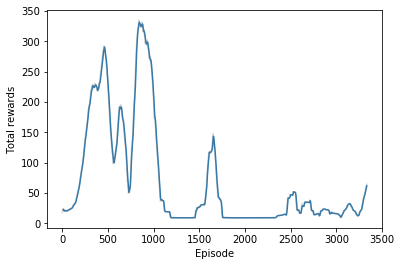

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

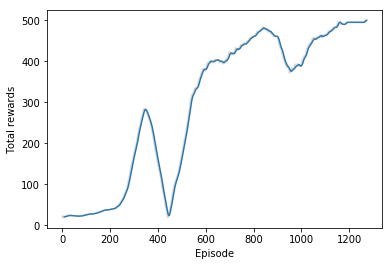

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

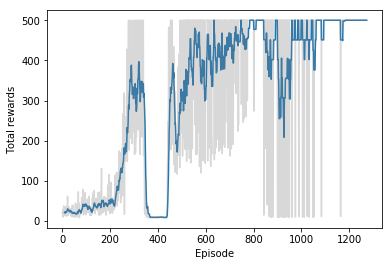

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [18]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [20]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 200.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 11.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.